#**Deep Learning and Computer Vision - Mini Project**

**NAME** - Ganesh Kumaran Masilamani

**STUDENT NUMBER** - 200434339

**PROJECT TITLE** - Deep Neural Networks for Image Classification

###**In this Notebook we will be using MobileNet Architecture as our deep Network to do image classification in MNIST dataset.**

#**DEEP NETWORK MODEL-8 --> MOBILENET**

In [1]:
#Libraries Imported
import time
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision.utils import make_grid
import torchvision
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
import pickle
%pip install torchviz
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from torchviz import make_dot
from datetime import datetime
Date_time = datetime.now()
date = Date_time.strftime("%d/%m/%Y")
Time = Date_time.strftime("%H:%M:%S")

  Created wheel for torchviz: filename=torchviz-0.0.2-cp37-none-any.whl size=4152 sha256=c4497b9bf7e0cef3e523306582cad37f10237fbdb33aaf02e37cbf5bf213c700
  Stored in directory: /root/.cache/pip/wheels/01/26/58/026ffd533dbe8b3972eb423da9c7949beca68d1c98ed9e8624
Successfully built torchviz


##**Loading the MNIST Dataset**

In [2]:
#Downloading and Loading the MNIST dataset 
def Load_mnist_data(batch_size, resize=None, root=os.path.join('MNIST_DATASET')):
    final_root = os.path.expanduser(root)
    Convolutional_Transformer = []

    #resizing the dataset to fit the Network architecture
    if resize:
        Convolutional_Transformer += [transforms.Resize(resize)]
    Convolutional_Transformer += [transforms.ToTensor()]
    Convolutional_Transformer = transforms.Compose(Convolutional_Transformer)

    #Downloading the MNIST dataset
    MNIST_traindata = torchvision.datasets.MNIST(root=final_root, train=True, transform=Convolutional_Transformer, download=True)
    MNIST_testdata = torchvision.datasets.MNIST(root=final_root, train=False, transform=Convolutional_Transformer, download=True)

    #loading the dataset and assign it to a variable
    Load_MNIST_traindata =torch.utils.data.DataLoader(MNIST_traindata, batch_size, shuffle=True)
    Load_MNIST_testdata =torch.utils.data.DataLoader(MNIST_testdata, batch_size, shuffle=False)
    return Load_MNIST_traindata, Load_MNIST_testdata

Convolutional_Transformer = transforms.Compose([transforms.Resize((32,32)), transforms.RandomHorizontalFlip(), transforms.ToTensor()])
MNIST_testdata = torchvision.datasets.MNIST(root='Mnist', train=False, transform=Convolutional_Transformer, download=True)

#load the function of the MNIST dataset to the train and test variable loader
Traindata_Loader, Testdata_Loader = Load_mnist_data(batch_size=32, resize=96, root=os.path.join('MNIST_DATASET'))

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting Mnist/MNIST/raw/train-images-idx3-ubyte.gz to Mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting Mnist/MNIST/raw/train-labels-idx1-ubyte.gz to Mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting Mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to Mnist/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting Mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to Mnist/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_DATASET/MNIST/raw/train-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_DATASET/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_DATASET/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST_DATASET/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting MNIST_DATASET/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST_DATASET/MNIST/raw

Processing...
Done!


##**Developing MobileNet Architecture**

In [3]:
#########################################################MOBILENET ARCHITECTURE####################################################################
#creating a convolutional network to parse with network-1 of the mobilenet
class Deep_convolutional_net(torch.nn.Module):
    def __init__(self, filter_in, kernel_size, padding, bias=True, stride=1):
        super(Deep_convolutional_net, self).__init__()
        self.deep_network = torch.nn.Conv2d(filter_in, filter_in, kernel_size=kernel_size, stride=stride, padding=padding, groups=filter_in, bias=bias)
    def forward(self, out):
        final_out = self.deep_network(out)
        return final_out

#first mobilenet Network is created and parsed with precreated convolutional network
class Deep_conv_stage1(torch.nn.Module):
    def __init__(self, filter_in, kernel_size, padding, bias=True, stride=1):
        super(Deep_conv_stage1, self).__init__()
        self.stage1 = torch.nn.Sequential(Deep_convolutional_net(filter_in, kernel_size, padding, stride, bias), torch.nn.BatchNorm2d(filter_in), torch.nn.ReLU())
    def forward(self, out):
        final_out = self.stage1(out)
        return final_out

#second mobilenet Network is created and initialised
class Deep_conv_stage2(torch.nn.Module):
    def __init__(self, filter_in, filter_out, kernel_size, padding, bias=True, stride=1):
        super(Deep_conv_stage2, self).__init__()
        self.stage2 = torch.nn.Sequential(nn.Conv2d(filter_in, filter_out, kernel_size, stride, padding, bias=bias), torch.nn.BatchNorm2d(filter_out), torch.nn.ReLU())
    def forward(self, out):
        final_out = self.stage2(out)
        return final_out

#MobileNet network is formed according to the architecture
class MobileNet(torch.nn.Module):
    def __init__(self, Channel_In, Channel_Out):
        super(MobileNet, self).__init__()
        self.MobileNet_convolutional_layer1 = torch.nn.Sequential(nn.Conv2d(Channel_In, 32, kernel_size=3, stride=2, padding=1, bias=False),
                                                                  torch.nn.BatchNorm2d(32),
                                                                  torch.nn.ReLU(),
                                                                  Deep_conv_stage1(32, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(32, 64, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(64, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(64, 128, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(128, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(128, 128, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(128, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(128, 256, kernel_size=3, stride=2, padding=1),  
                                                                  Deep_conv_stage1(256, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(256, 256, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(256, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(256, 512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(512, 512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(512, 512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(512, 512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(512, 512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(512, 512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(512, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(512, 1024, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage1(1024, kernel_size=3, stride=2, padding=1),
                                                                  Deep_conv_stage2(1024, 1024, kernel_size=3, stride=2, padding=1))      
        self.MobileNet_convolutional_layer2 = torch.nn.Linear(1024, Channel_Out)
        
    def forward(self, out):
        out1 = self.MobileNet_convolutional_layer1(out)
        out2 = torch.nn.functional.adaptive_avg_pool2d(out1, (1, 1))
        out3 = out2.view(out2.size(0), -1)
        final_out = self.MobileNet_convolutional_layer2(out3)
        return final_out

#Updating the weights of the network
Network_arch = MobileNet(1,10)
#Initialize the Weights and display the Network architecture
def Initialise_weights(layer_weight):
    if type(layer_weight) == torch.nn.Conv2d:
        torch.nn.init.xavier_uniform_(layer_weight.weight)
Network_arch.apply(Initialise_weights)

MobileNet(
  (MobileNet_convolutional_layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Deep_conv_stage1(
      (stage1): Sequential(
        (0): Deep_convolutional_net(
          (deep_network): Conv2d(32, 32, kernel_size=(3, 3), stride=(True, True), padding=(1, 1), groups=32)
        )
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (4): Deep_conv_stage2(
      (stage2): Sequential(
        (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (5): Deep_conv_stage1(
      (stage1): Sequential(
        (0): Deep_convolutional_net(
          (deep_network): Conv2d(64, 64, kernel_size=(3, 3)

##**Plotting Architecture flow-diagram of our MobileNet Network**

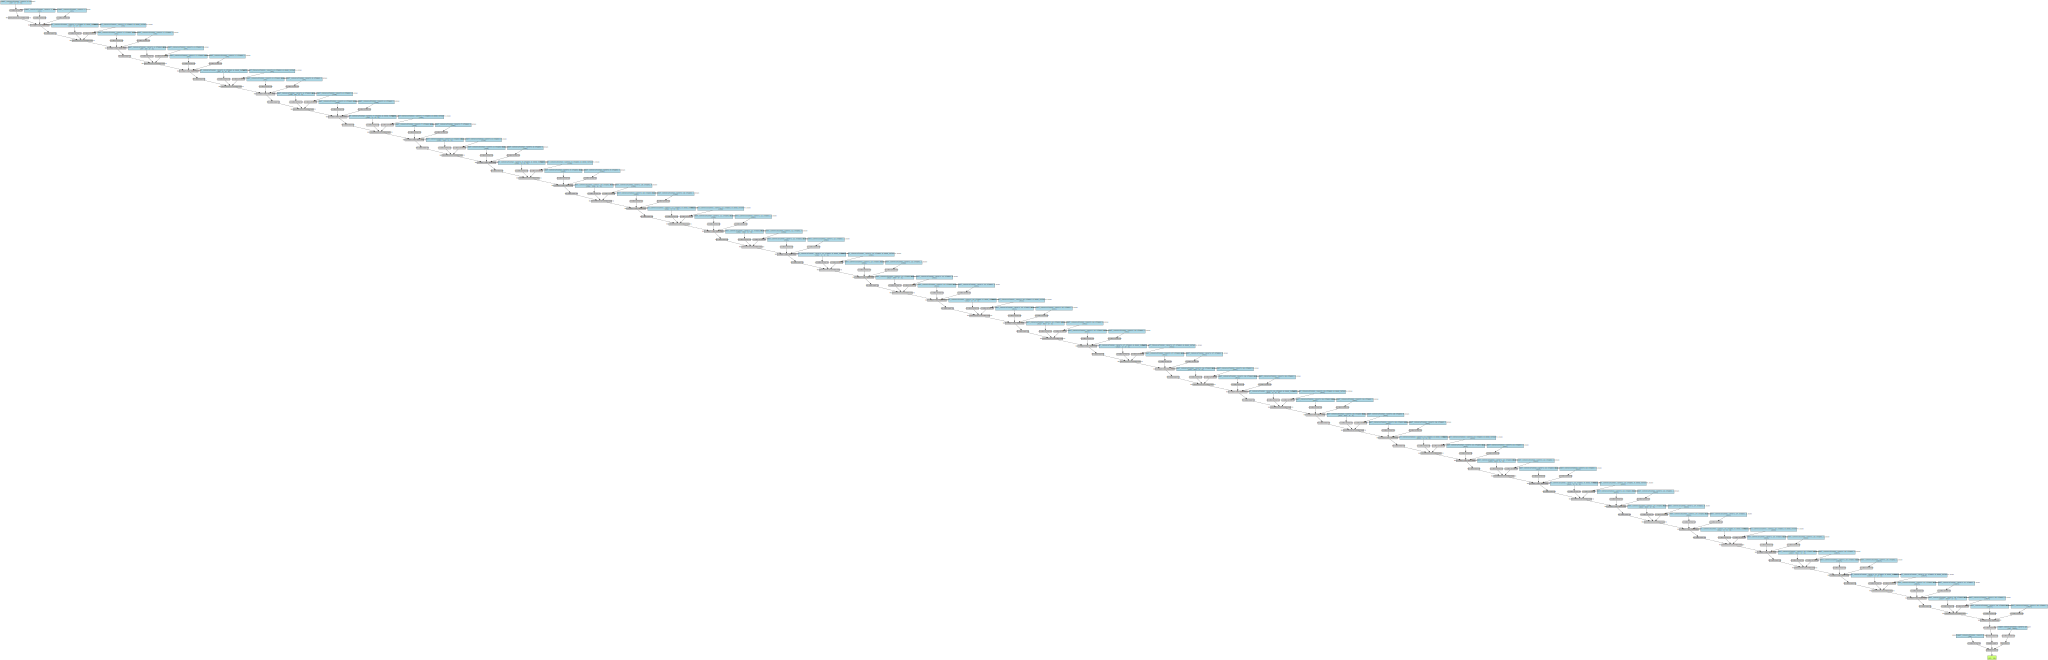

In [4]:
#Plotting the MobileNet Architecture flowchart which was developed above.
Sample = torch.rand(32, 1, 3, 3)
MobileNet_Architecture_plot = make_dot(Network_arch(Sample), params=dict(Network_arch.named_parameters()))
#displaying the MobileNet flow diagram
display(MobileNet_Architecture_plot)

In [5]:
#enumerating testdata with batch index of source and the target
testdata_ex = enumerate(Testdata_Loader)
batch_idx, (Val_ex_data, Val_ex_targets) = next(testdata_ex)
#printing the shape of the indexed data
print(Val_ex_data.shape)

torch.Size([32, 1, 96, 96])


##**Setting Hyperparameters**

In [6]:
#Initialization of Hyperparameters
#Number of epochs
EPOCHS = 10
#Batch size and the learning rate
batch_size= 32
Learning_rate= 0.1
#Loss Function
Loss_criterion_function = torch.nn.CrossEntropyLoss()
device =torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
#For storing the generated train and test accuracy and plotting
def show_train_hist(hist, show=False, save=False, path='Train_hist.png'):
    x = range(len(hist['train_accuracy']))
    y1 = hist['train_accuracy']
    y2 = hist['test_accuracy']
    #plotting
    plt.plot(x, y1, label='train_accuracy')
    plt.plot(x, y2, label='test_accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc=4)
    plt.grid(True)
    plt.tight_layout()
    #saving the generated outputs
    if save:
        plt.savefig(path)
    if show:
        plt.show()
    else:
        plt.close()

##**Evaluation --> Training and Testing**

In [8]:
#Test Accuracy and loss Evaluation
def Evaluate_Accuracy(dataset_eval_iteration, Network_arch, Loss_criterion_function, device=device): 
  #Evaluate accuracy of a model on the testset
  #In evaluation mode, we will be using the dropout and normalization layers
  testset_initial=len(dataset_eval_iteration.dataset)
  test_loss=0
  test_accuracy=0
  Network_arch.eval()
  with torch.no_grad():
    for X, y in dataset_eval_iteration:
        #transfer the produced data to the device
        X = X.to(device)
        y = y.to(device)   
        outputs = Network_arch(X)
        #calculating the test accuracy and loss and appending it                                                   
        test_loss += Loss_criterion_function(outputs,y).item()                 
        test_accuracy += (outputs.argmax(1) == y).type(torch.float).sum().item()  
  test_accuracy = test_accuracy/testset_initial  
  test_loss /= testset_initial
  return test_accuracy, test_loss

In [9]:
#Cross validating the predicted values for plotting the confusion matrix and predict the correct and incorrect samples
def Cross_validate_predicted_data(Network_arch, dataset_eval_iteration):
    Data_pics_label = []
    Data_pics_val = []
    Network_arch.eval()
    for X, y in dataset_eval_iteration:
      X = X.to(device)
      y = y.to(device)
      prediction = Network_arch(X)
      with torch.no_grad():
            Final_predict = F.softmax(prediction, dim = -1)
            Data_pics_label.append(y.cpu())
            Data_pics_val.append(Final_predict.cpu())
    out1 = torch.cat(Data_pics_label)
    out2 = torch.cat(Data_pics_val)
    return out1, out2

In [10]:
#Training and Evaluating the model 
#Training is performed on the train dataset
#Testing (Evaluation) is performed in the test dataset
#Train and evaluate the model using the device GPU or else with CPU
def training(Network_arch, Load_MNIST_traindata, Load_MNIST_testdata, Loss_criterion_function, EPOCHS, batch_size, device, Learning_rate=None):    
    print("---------------------------------------------------")
    print("Model Training and Testing Start date:", date)
    print("Model Training and Testing starting time:", Time)
    print("---------------------------------------------------")
    print('MobileNet Architecture Training and Testing Begins!')
    Network_arch.to(device)
    #Initialization of the optimizer
    optimizer = optim.SGD(Network_arch.parameters(), lr=Learning_rate)
    #FOR CALCULATING THE EPOCHS
    for Epoch in range(EPOCHS):
        #Network is trained on the training mode
        Network_arch.train()
        cv = 0
        ep_start = time.time()
        Sum_training_Loss = torch.tensor([0.0], device=device)
        Sum_training_Accuracy = torch.tensor([0.0], device=device)
        #FOR CALCULATING THE TRAIN LOSS AND TRAIN ACCURACY
        for X, y in Load_MNIST_traindata:
            optimizer.zero_grad()
            X = X.to(device) 
            y = y.to(device)
            conv_y = Network_arch(X)
            final_end_loss = Loss_criterion_function(conv_y, y)
            final_end_loss.backward()
            optimizer.step()
            with torch.no_grad():
                y = y.long()
                Sum_training_Loss += final_end_loss.float()
                Sum_training_Accuracy += (torch.sum((torch.argmax(conv_y, dim=1) == y))).float()
                cv += y.shape[0]
                final_loss = Sum_training_Loss/cv
                final_train_accuracy = Sum_training_Accuracy/cv
                #final_train_accuracy_out =final_train_accuracy.to('cpu').numpy()
        #FOR CALCULATING THE TEST ACCURACY and loss
        final_test_accuracy, final_test_loss = Evaluate_Accuracy(Load_MNIST_testdata, Network_arch, Loss_criterion_function, device) 
        Start_Time=datetime.now()
        train_test_Start_Time = Start_Time.strftime("%H:%M:%S")
        print("-------------------------------------------------------------------------------------------------------------------------------------------")
        #print(f'Epoch_start_time: {train_test_Start_Time}')
        print('Epoch--> %d\t Train_Loss: %.4f\t Train_Accuracy: %.2f\t    Test_Loss: %.4f\t  Test_Accuracy: %.2f\t  Time_Duration: %.1f sec\t' % (Epoch + 1, final_loss, final_train_accuracy*100, final_test_loss, final_test_accuracy*100, time.time() - ep_start))
        print("-------------------------------------------------------------------------------------------------------------------------------------------")
        save_dir = './CV_miniproject_results/'
        #Creating a folder to store the results
        if not os.path.exists(save_dir):
          os.mkdir(save_dir)
        #Storing and tracking the outputs and plotting
        train_hist = {}
        train_hist['train_accuracy'] = []
        train_hist['test_accuracy'] = []
        train_hist['train_accuracy'].append(final_train_accuracy)
        train_hist['test_accuracy'].append(final_test_accuracy)
        #saving outputs to the created directory
        with open(save_dir + '/train_hist.pkl', 'wb') as f:
          pickle.dump(train_hist, f)
        show_train_hist(train_hist, save=True, path=save_dir + '/CV_miniproject_Train_hist.png')

#Training and evaluating the Network model 
MobileNet_History = training(Network_arch, Traindata_Loader, Testdata_Loader, Loss_criterion_function, EPOCHS, batch_size, device, Learning_rate)
End_Time=datetime.now()
end_date = End_Time.strftime("%d/%m/%Y")
end_time = End_Time.strftime("%H:%M:%S")
print('MobileNet Architecture Training and Testing Completed!')
print("--------------------------------------------------")
print("Model Training and Testing End date:", end_date)
print("Model Training and Testing End time:", end_time)
print("--------------------------------------------------")

---------------------------------------------------
Model Training and Testing Start date: 17/05/2021
Model Training and Testing starting time: 07:56:37
---------------------------------------------------
MobileNet Architecture Training and Testing Begins!
-------------------------------------------------------------------------------------------------------------------------------------------
Epoch--> 1	 Train_Loss: 0.0113	 Train_Accuracy: 90.17	    Test_Loss: 0.0031	  Test_Accuracy: 97.86	  Time_Duration: 101.5 sec	
-------------------------------------------------------------------------------------------------------------------------------------------
-------------------------------------------------------------------------------------------------------------------------------------------
Epoch--> 2	 Train_Loss: 0.0033	 Train_Accuracy: 97.36	    Test_Loss: 0.0020	  Test_Accuracy: 98.59	  Time_Duration: 101.5 sec	
---------------------------------------------------------------------

In [11]:
#getting the output of the tensor(weights)
with torch.no_grad():
  Network_arch.to('cpu')
  final_tensor_output = Network_arch(Val_ex_data)
#printing the output
print(final_tensor_output)

tensor([[-2.4011e+00, -6.0411e-01,  3.6806e+00,  5.3437e-01,  6.7274e-01,
         -3.8091e+00, -5.9360e+00,  8.8522e+00, -1.1966e-01, -6.1479e-01],
        [-3.7508e-02, -1.1293e+00,  8.6568e+00,  1.2436e-01,  4.1127e-01,
         -2.1361e+00,  6.3540e-01, -1.6309e-01, -2.4040e+00, -3.5224e+00],
        [ 1.4963e-01,  1.0098e+01, -2.6667e-01, -4.5307e-01, -2.8539e+00,
          1.5721e+00,  1.2410e+00, -4.7596e+00, -8.6945e-01, -3.3963e+00],
        [ 7.7793e+00, -1.8729e+00,  8.6379e-02, -4.7173e+00, -8.5409e-01,
          8.0636e-01,  2.8584e+00, -2.8911e+00, -4.9864e-01,  3.5018e-01],
        [-1.6386e+00, -5.2979e-01, -1.1928e+00, -2.4788e+00,  7.7061e+00,
         -2.6795e+00, -1.8416e-01, -2.4900e+00,  3.5635e-01,  2.9247e+00],
        [ 2.5686e-01,  1.1200e+01,  1.6499e+00, -2.5720e+00, -7.7353e-01,
         -1.0858e+00, -3.1493e-01, -2.6591e+00, -1.4360e+00, -3.7963e+00],
        [-2.5985e+00, -1.5677e+00, -8.1584e-01, -3.0669e+00,  9.4149e+00,
         -2.7774e+00,  2.0729e+0

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


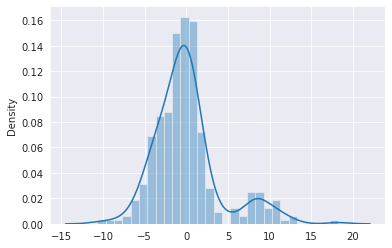

In [12]:
#histogram for the tensor values
sns.distplot(final_tensor_output)

##**Verification --> How well our Network predicts the data accurately**

GROUNDTRUTH IMAGE


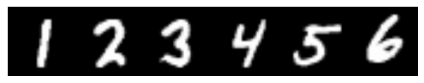

In [13]:
#for testing our model after training, we have printed the classes of MNIST data for the groundtruth image 
#In the evaluation phase we printed the classes of MNIST data with their predicted class
#we compare how correctly it predicted the classes between orginal and the predicted data
MNIST_Class = ('0', '1', '2', '3', '4','5', '6', '7', '8', '9')
device =torch.device('cpu')
for X, y in Testdata_Loader:
  X = X[:6]
  y = y[:6] 
  def imshow(figure):
    figure = figure
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()
    plt.imshow(np.transpose(figure.numpy(), (1,2,0)))
    plt.show()
#Plotting the Groundtruth image
center = "GROUNDTRUTH IMAGE"
print("{center:^10}".format(center=center))
imshow(make_grid(X))

In [14]:
#Getting the predicted classes
Final_Out = Network_arch(X)
_, prediction = torch.max(Final_Out, 1)
#printing the classes of groundtruth data
print("----------------------------------------")
print('Orginal images classes: ',' '.join(MNIST_Class[y[GT_data_out]] for GT_data_out in range(6)))
print("----------------------------------------")
#printing the classes of prediction data
print('Predicted images classes: ',' '.join(MNIST_Class[prediction[Pred_data_out]] for Pred_data_out in range(6)))
print("----------------------------------------")

----------------------------------------
Orginal images classes:  1 2 3 4 5 6
----------------------------------------
Predicted images classes:  1 2 3 4 5 6
----------------------------------------


In [15]:
#Calculating the induvidual accuracy of Each classes defined
accurate_class_pred = list(range(10))
Combined_class_accurate = list(range(10))
with torch.no_grad():
    for X, y in Testdata_Loader:
      X = X.to(device) 
      y = y.to(device)
      Final_Out = Network_arch(X)
      _, Induvidual_class_prediction = torch.max(Final_Out, 1)
      CIF_out = (Induvidual_class_prediction == y)
      for Induvidual_out in range(6):
        accurate_class_pred[y[Induvidual_out]] += CIF_out[Induvidual_out].item()
        Combined_class_accurate[y[Induvidual_out]] += 1 
#Printing the accuracy of Each classes       
for Induvidual_class_accuracy in range(10):
  print("---------------------------")
  print('Accuracy of %5s : %d %%' % (MNIST_Class[Induvidual_class_accuracy], accurate_class_pred[Induvidual_class_accuracy] / Combined_class_accurate[Induvidual_class_accuracy] *100))
  print("---------------------------")

---------------------------
Accuracy of     0 : 98 %
---------------------------
---------------------------
Accuracy of     1 : 100 %
---------------------------
---------------------------
Accuracy of     2 : 99 %
---------------------------
---------------------------
Accuracy of     3 : 99 %
---------------------------
---------------------------
Accuracy of     4 : 100 %
---------------------------
---------------------------
Accuracy of     5 : 97 %
---------------------------
---------------------------
Accuracy of     6 : 99 %
---------------------------
---------------------------
Accuracy of     7 : 100 %
---------------------------
---------------------------
Accuracy of     8 : 100 %
---------------------------
---------------------------
Accuracy of     9 : 100 %
---------------------------


In [16]:
#Seperating the correct and incorrect predictions and appending it to a seperate list
Correct_Data = []
Incorrect_Data = []
Label_for_pic, Prediction = Cross_validate_predicted_data(Network_arch, Testdata_Loader)
Predicted_label = torch.argmax(Prediction, 1)
MNIST_Classes = MNIST_testdata.classes
Accurate_prediction = torch.eq(Label_for_pic, Predicted_label)
for i, j, Correct_data_prediction in zip(Label_for_pic, Prediction, Accurate_prediction):
    if Correct_data_prediction:
      Correct_Data.append((i, j))
    else:
      Incorrect_Data.append((i, j))
#Randomly sorting the samples
Correct_Data.sort(key = lambda Correct_samples: torch.max(Correct_samples[1], -1).values)
Incorrect_Data.sort(key = lambda Incorrect_samples: torch.max(Incorrect_samples[1], -1).values)

**Examples of Correct Predictions**

In [17]:
#Examples of Correct Prediction
def Correct_Prediction(Correct_label_predict, MNIST_Classes):
    for Sample in range(1*5):
        Correct_Label, Prediction = Correct_label_predict[Sample]
        Correct_pred, Correctly_predicted_label = torch.max(Prediction, -1)
        Original_class = MNIST_Classes[Correct_Label]
        Correctly_Predicted_class = MNIST_Classes[Correctly_predicted_label ]
        print("------------------------------------")
        print(f'Orginal images class   :  {Original_class}')
        print("------------------------------------")
        print(f'Predicted images class :  {Correctly_Predicted_class}')
        print("------------------------------------")
Correct_Prediction(Correct_Data, MNIST_Classes)

------------------------------------
Orginal images class   :  6 - six
------------------------------------
Predicted images class :  6 - six
------------------------------------
------------------------------------
Orginal images class   :  3 - three
------------------------------------
Predicted images class :  3 - three
------------------------------------
------------------------------------
Orginal images class   :  0 - zero
------------------------------------
Predicted images class :  0 - zero
------------------------------------
------------------------------------
Orginal images class   :  5 - five
------------------------------------
Predicted images class :  5 - five
------------------------------------
------------------------------------
Orginal images class   :  7 - seven
------------------------------------
Predicted images class :  7 - seven
------------------------------------


**Examples of Incorrect Predictions**

In [18]:
#Examples of Incorrect Prediction
def Incorrect_Prediction(Incorrect_label_predict, MNIST_Classes):
    for Sample in range(1*5):
        Incorrect_Label, Prediction = Incorrect_label_predict[Sample]
        Incorrect_pred, Incorrectly_predicted_label = torch.max(Prediction, -1)
        Original_class = MNIST_Classes[Incorrect_Label]
        Incorrectly_Predicted_class = MNIST_Classes[Incorrectly_predicted_label ]
        print("------------------------------------")
        print(f'Orginal images class   :  {Original_class}')
        print("------------------------------------")
        print(f'Predicted images class :  {Incorrectly_Predicted_class}')
        print("------------------------------------")
Correct_Prediction(Incorrect_Data, MNIST_Classes)

------------------------------------
Orginal images class   :  6 - six
------------------------------------
Predicted images class :  4 - four
------------------------------------
------------------------------------
Orginal images class   :  8 - eight
------------------------------------
Predicted images class :  7 - seven
------------------------------------
------------------------------------
Orginal images class   :  6 - six
------------------------------------
Predicted images class :  2 - two
------------------------------------
------------------------------------
Orginal images class   :  3 - three
------------------------------------
Predicted images class :  8 - eight
------------------------------------
------------------------------------
Orginal images class   :  8 - eight
------------------------------------
Predicted images class :  2 - two
------------------------------------


**Confusion Matrix**

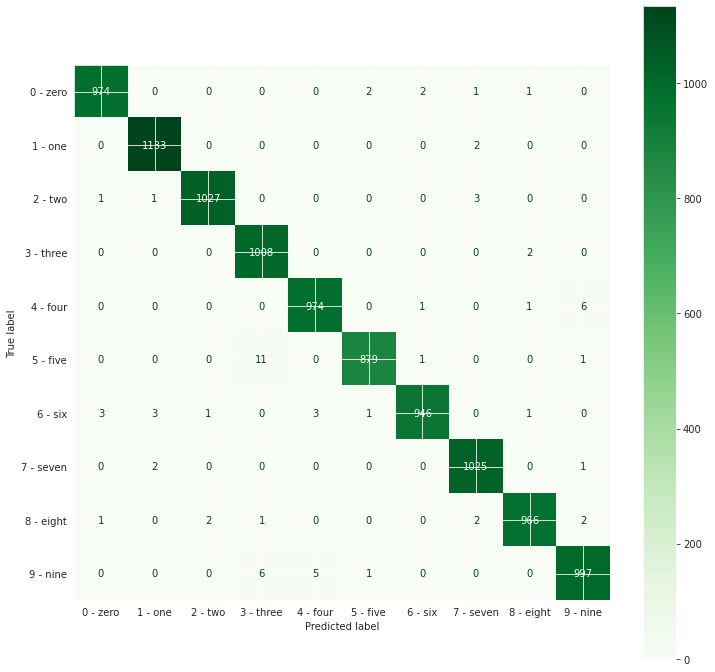

In [19]:
#Plotting the confusion matrix
Figure = plt.figure(figsize=(12, 12))
Axis = Figure.add_subplot(1, 1, 1)
Confusion_Matrix = confusion_matrix(Label_for_pic, Predicted_label)
Confusion_Heatmap_display = ConfusionMatrixDisplay(Confusion_Matrix, MNIST_Classes)
Final_Heatmap_for_Predicted_data = Confusion_Heatmap_display.plot(ax=Axis, values_format='d', cmap = 'Greens')

In [20]:
#I have Executed the code in Google Colab pro. so that, I have printed the usage of gpu provided
GPU_Usage_data = !nvidia-smi
GPU_Usage_data  = '\n'.join(GPU_Usage_data )
if GPU_Usage_data .find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(GPU_Usage_data )

Mon May 17 08:14:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0    38W / 250W |   1293MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------